# Project- Recommendation Systems: Amazon product reviews

By Adam M. Lang<br>
December 16, 2020


----
### Context: 
-------

Online E-commerce websites like Amazon, Flipkart uses different recommendation models to provide different suggestions to different users. Amazon currently uses item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

---------
### Objective:
------------
Build a recommendation system to recommend products to customers based on the their previous ratings for other products.

--------
### Dataset Attributes
------------
- userId : Every user identified with a unique id
- productId : Every product identified with a unique id
- Rating : Rating of the corresponding product by the corresponding user
- timestamp : Time of the rating ( ignore this column for this exercise)

### Data Source:
Amazon Reviews data: http://jmcauley.ucsd.edu/data/amazon/

Electronics (ratings only) dataset: This dataset includes no metadata or reviews, but only (user,Product,rating,Product Name) 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import Required Libraries

In [3]:
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

### Read the dataset 

In [4]:
#Import the data set
df = pd.read_csv('/content/drive/MyDrive/ratings_Electronics.csv', header=None)

df.columns = ['user_id', 'prod_id', 'rating', 'prod_name']
df = df.drop('prod_name', axis=1)
df_copy = df.copy(deep=True)

In [5]:
# see few rows of the imported dataset
df.head()

,user_id,prod_id,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


### Exploratory data analysis

In [6]:
# Check the number of rows and columns
rows, columns = df.shape
print("No of rows: ", rows) 
print("No of columns: ", columns) 

No of rows:  7824482
No of columns:  3


In [7]:
#Check Data types
df.dtypes

user_id     object
prod_id     object
rating     float64
dtype: object

In [8]:
# Check for missing values present
print('Number of missing values across columns-\n', df.isnull().sum())

Number of missing values across columns-
 user_id    0
prod_id    0
rating     0
dtype: int64


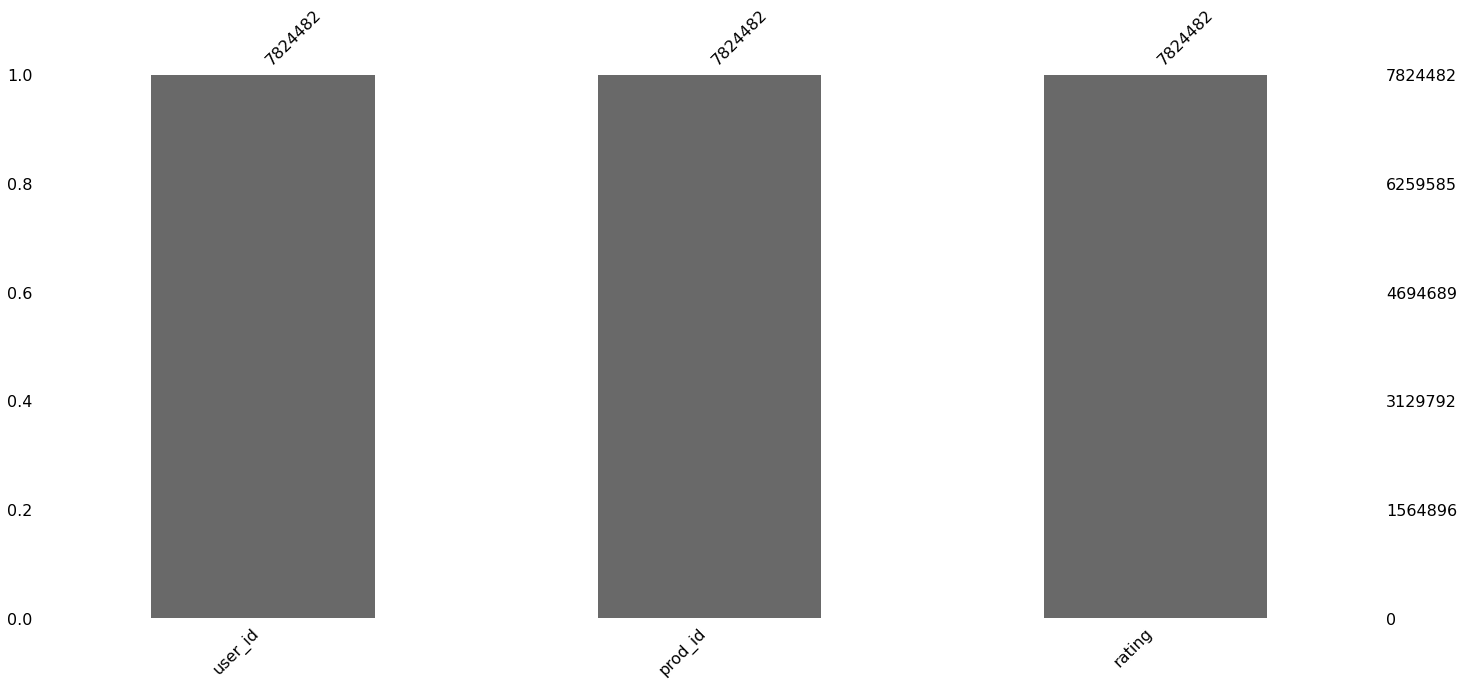

In [9]:
#check with missingno library
import missingno as msno

#visualize missing values
msno.bar(df);


**Observations:** 
- This data set has 7,824,482 rows and 3 columns. 
- There are no missing values in the dataset. 
- This is a very large dataset.

In [10]:
# Summary statistics of 'rating' variable
df.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,rating
count,7824482.00000
mean,4.01234
std,1.38091
min,1.00000
25%,3.00000
50%,5.00000
75%,5.00000
max,5.00000


**Observations:**
- There are 7,824,482 count of total ratings which is consistent with the df summary we obtained.
- The minimum rating is 1.
- The maximum rating is 5.
- The mean rating is 4.01.
- Th 1st quartile (25%) is 3.0 and the 3rd quartile (75%) is 5.0 which means that the data seems to be skewed towards higher ratings. In fact, the median being higher than the mean implies that the distribution may be negatively skewed or left skewed.  
- Based on the evaluation of the quartiles it appears more people give favorable ratings to the products than non-favorable.

In [11]:
#check describe on object variables
df.describe(include='object')

,user_id,prod_id
count,7824482,7824482
unique,4201696,476002
top,A5JLAU2ARJ0BO,B0074BW614
freq,520,18244


**Observations**
- There are the same number of user_id's as there are prod_id which is 7,824,482.
- There are however 4,201,696 unique user_ids with less product ids at 476,002.
- The top user_id is A5JLAU2ARJOBO with a frequency of 520.
- The top prod_id is B0074BW614 with a frequency of 18,244.

**Let's check the ratings distribution and visualize it.**

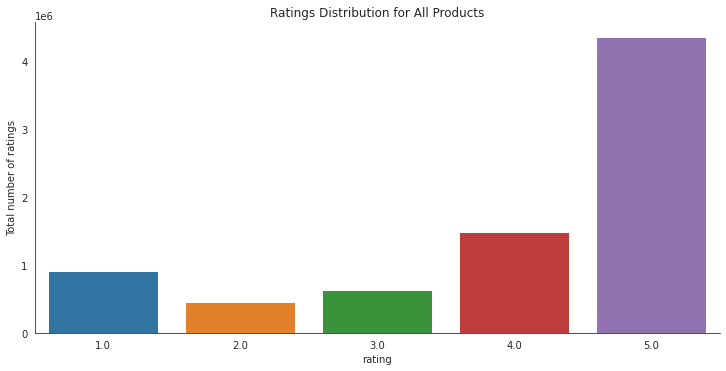

In [14]:
# Check the distribution of the ratings 
with sns.axes_style('white'):
    g = sns.factorplot("rating", data=df, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings") 
    plt.title('Ratings Distribution for All Products')
    plt.show()

**Let's now check the number of unique users and items in the dataset.**

In [15]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', df['user_id'].nunique())
print('Number of unique ITEMS in Raw data = ', df['prod_id'].nunique())

Number of unique USERS in Raw data =  4201696
Number of unique ITEMS in Raw data =  476002


In [16]:
# Top 10 users based on rating
most_rated = df.groupby('user_id').size().sort_values(ascending=False)[:10]
most_rated

user_id
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
dtype: int64

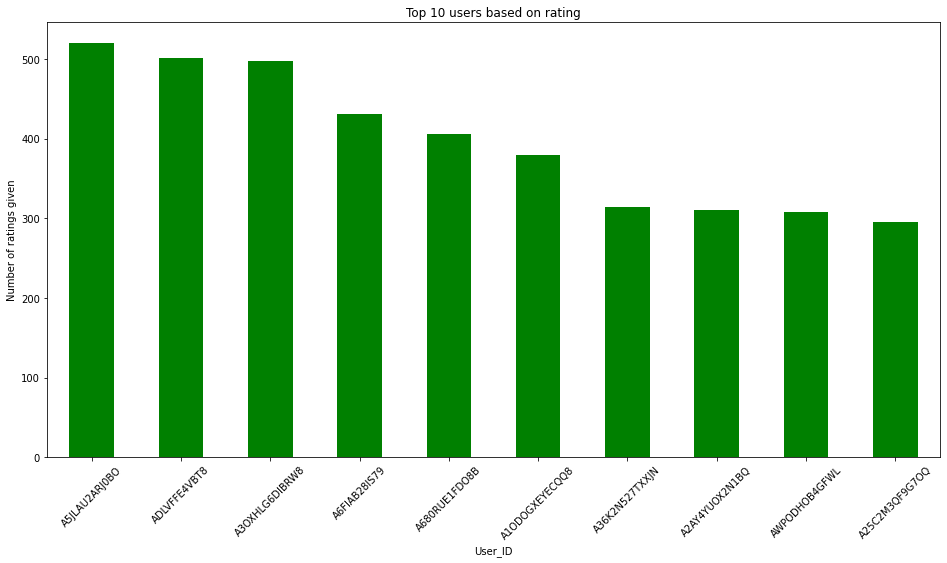

In [17]:
#visualize top 10 users based on rating
most_rated.plot(kind='bar',figsize=(16,8),color='g')
#title and labels of plot
plt.title('Top 10 users based on rating')
plt.xlabel('User_ID')
plt.ylabel('Number of ratings given')
plt.xticks(rotation=45)

plt.show()


### Data preparation as per requirement on number of minimum ratings

**Let's take a subset of dataset (by only keeping the users who have given 50 or more number of ratings) to make the dataset less sparse and easy to work with.**

In [19]:
counts = df['user_id'].value_counts()
df_final = df[df['user_id'].isin(counts[counts >= 50].index)]

In [21]:
print('The number of observations in the final data =', len(df_final))
print('Number of unique USERS in the final data = ', df_final['user_id'].nunique())
print('Number of unique ITEMS in the final data = ', df_final['prod_id'].nunique())

The number of observations in the final data = 125871
Number of unique USERS in the final data =  1540
Number of unique ITEMS in the final data =  48190


**Observations:** 
- df_final has users who have rated 50 or more items and **we will using df_final to build recommendation systems.**
- df_final has 125,871 observations which is an easier size dataframe to work with.
- df_final has 1,540 unique users.
- df_final has 48,190 unique items.

**Let's calculate the density of the rating matrix**

In [22]:
final_ratings_matrix = df_final.pivot(index = 'user_id', columns ='prod_id', values = 'rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))
final_ratings_matrix.head()

Shape of final_ratings_matrix:  (1540, 48190)
given_num_of_ratings =  125871
possible_num_of_ratings =  74212600
density: 0.17%


prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,1400698987,1400699169,1685560148,3744295508,7562434166,787988002X,8862935307,8862936826,9043413585,9573212900,9573212919,9575871979,9800359788,9981719005,9981734241,9981739588,9983722615,998376234X,9983891212,9984922626,9984984362,9985511298,9985511476,9985525264,9985696999,9989360391,B000000O48,B000001OKH,B000001OL6,...,B00KSTODWY,B00KT17TZ4,B00KTIYN7O,B00KU4RD4M,B00KV6FFN0,B00KVLY8E2,B00KVNY2KA,B00KW2W6B2,B00KW3OFG0,B00KWHMR6G,B00KWL62QI,B00KWMNDDM,B00KWPRSJY,B00KWWY1PQ,B00KXAFYZS,B00KXMN08E,B00KXUHX9S,B00KYA7CT8,B00KYMCJF8,B00L0YFJHY,B00L1I727Y,B00L1I80K2,B00L1NZTSS,B00L21HC7A,B00L2442H0,B00L26YDA4,B00L2P3TRS,B00L3YHF6O,B00L403O94,B00L43HAY6,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Build Popularity based Recommendation System by Averaging

In [23]:
#evaluate df_final
df_final.head()

,user_id,prod_id,rating
94,A3BY5KCNQZXV5U,0594451647,5.0
118,AT09WGFUM934H,0594481813,3.0
177,A32HSNCNPRUMTR,0970407998,1.0
178,A17HMM1M7T9PJ1,0970407998,4.0
492,A3CLWR1UUZT6TG,0972683275,5.0


In [24]:
# make a dataframe where you have the average rating and ratings count of each product in descending order of ratings count
#average rating
avg_rating = df_final.groupby('prod_id').mean()['rating']
#count of rating
rating_count = df_final.groupby('prod_id').count()['rating']
#make dataframe
rating_df = pd.DataFrame({'avg_rating':avg_rating,'count_rating':rating_count})
#sort values descending
final_rating = rating_df.sort_values(by='count_rating',ascending=False)

#print dataframe
final_rating.head()

,avg_rating,count_rating
prod_id,,
B0088CJT4U,4.218447,206
B003ES5ZUU,4.864130,184
B000N99BBC,4.772455,167
B007WTAJTO,4.701220,164
B00829TIEK,4.436242,149


In [25]:
#defining a function to get the top n products based on highest average rating and some minimum interactions (minimum number of ratings) of that product
def top_n_products(final_rating, n, min_interaction=100):
    ratings = final_rating[final_rating['count_rating'] > min_interaction]
    ratings = ratings.sort_values(by='avg_rating',ascending=False)
    return ratings.index[:n]

#### Recommending top 5 products based on popularity and with minimum interactions of 50

In [26]:
list(top_n_products(final_rating,5,50))

['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']

#### Recommending top 5 products based on popularity and with minimum interactions of 100

In [27]:
list(top_n_products(final_rating,5,100))

['B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B002V88HFE', 'B004CLYEDC']

We have recommended the top 5 products by using popularity recommendation system.

### Build Collaborative Filtering based Recommendation System

**Let's first compute the user-item interactions matrix by making the userid as index**

In [28]:
interactions_matrix = df_final.pivot(index='user_id', columns='prod_id', values='rating')
interactions_matrix

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,1400698987,1400699169,1685560148,3744295508,7562434166,787988002X,8862935307,8862936826,9043413585,9573212900,9573212919,9575871979,9800359788,9981719005,9981734241,9981739588,9983722615,998376234X,9983891212,9984922626,9984984362,9985511298,9985511476,9985525264,9985696999,9989360391,B000000O48,B000001OKH,B000001OL6,...,B00KSTODWY,B00KT17TZ4,B00KTIYN7O,B00KU4RD4M,B00KV6FFN0,B00KVLY8E2,B00KVNY2KA,B00KW2W6B2,B00KW3OFG0,B00KWHMR6G,B00KWL62QI,B00KWMNDDM,B00KWPRSJY,B00KWWY1PQ,B00KXAFYZS,B00KXMN08E,B00KXUHX9S,B00KYA7CT8,B00KYMCJF8,B00L0YFJHY,B00L1I727Y,B00L1I80K2,B00L1NZTSS,B00L21HC7A,B00L2442H0,B00L26YDA4,B00L2P3TRS,B00L3YHF6O,B00L403O94,B00L43HAY6,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A100WO06OQR8BQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A105S56ODHGJEK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A105TOJ6LTVMBG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A10AFVU66A79Y1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZBXKUH4AIW3X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AZCE11PSTCH1L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AZMY6E8B52L2T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

**Let's fill all the missing values by zero since cosine similarity can't work with missing values**

In [29]:
interactions_matrix.fillna(0,inplace=True)
interactions_matrix.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,1400698987,1400699169,1685560148,3744295508,7562434166,787988002X,8862935307,8862936826,9043413585,9573212900,9573212919,9575871979,9800359788,9981719005,9981734241,9981739588,9983722615,998376234X,9983891212,9984922626,9984984362,9985511298,9985511476,9985525264,9985696999,9989360391,B000000O48,B000001OKH,B000001OL6,...,B00KSTODWY,B00KT17TZ4,B00KTIYN7O,B00KU4RD4M,B00KV6FFN0,B00KVLY8E2,B00KVNY2KA,B00KW2W6B2,B00KW3OFG0,B00KWHMR6G,B00KWL62QI,B00KWMNDDM,B00KWPRSJY,B00KWWY1PQ,B00KXAFYZS,B00KXMN08E,B00KXUHX9S,B00KYA7CT8,B00KYMCJF8,B00L0YFJHY,B00L1I727Y,B00L1I80K2,B00L1NZTSS,B00L21HC7A,B00L2442H0,B00L26YDA4,B00L2P3TRS,B00L3YHF6O,B00L403O94,B00L43HAY6,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Here user id (index) is of the object data type. We will replacing the user id by numbers starting from 0 to 1539 (for all user ids) so that the index is of integer type and represents a user id in the same format**

In [30]:
interactions_matrix['user_index'] = np.arange(0, interactions_matrix.shape[0], 1)
interactions_matrix.set_index(['user_index'], inplace=True)

# Actual ratings given by users
interactions_matrix.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,1400698987,1400699169,1685560148,3744295508,7562434166,787988002X,8862935307,8862936826,9043413585,9573212900,9573212919,9575871979,9800359788,9981719005,9981734241,9981739588,9983722615,998376234X,9983891212,9984922626,9984984362,9985511298,9985511476,9985525264,9985696999,9989360391,B000000O48,B000001OKH,B000001OL6,...,B00KSTODWY,B00KT17TZ4,B00KTIYN7O,B00KU4RD4M,B00KV6FFN0,B00KVLY8E2,B00KVNY2KA,B00KW2W6B2,B00KW3OFG0,B00KWHMR6G,B00KWL62QI,B00KWMNDDM,B00KWPRSJY,B00KWWY1PQ,B00KXAFYZS,B00KXMN08E,B00KXUHX9S,B00KYA7CT8,B00KYMCJF8,B00L0YFJHY,B00L1I727Y,B00L1I80K2,B00L1NZTSS,B00L21HC7A,B00L2442H0,B00L26YDA4,B00L2P3TRS,B00L3YHF6O,B00L403O94,B00L43HAY6,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Let's first define a function to get similar users to a particular user**

In [31]:
# defining a function to get similar users and return the most similar users and thir similarity scores
def similar_users(user_index, interactions_matrix):
    similarity = []
    for user in interactions_matrix.index:
      sim = cosine_similarity([interactions_matrix.loc[user_index]], [interactions_matrix.loc[user]])
      similarity.append((user, sim))
#sort similar users and similarity scores
    similarity.sort(key=lambda x: x[1], reverse=True)
    most_similar_users = [tup[0] for tup in similarity]
    similarity_score = [tup[1] for tup in similarity]
    most_similar_users.remove(user_index)
    similarity_score.remove(similarity_score[0])

#return similar users and similarity score
    return most_similar_users, similarity_score


#### Finding out top 10 similar users to the user index 3 and their similarity score

In [32]:
similar = similar_users(3, interactions_matrix)[0][0:10]
similar

[320, 12, 793, 261, 156, 1493, 1250, 567, 753, 1360]

In [33]:
# printing the original user ids associated with the above user index
for i in similar:
    print(final_ratings_matrix.index[i])

A1TQBAHI3M4ZBQ
A10ZFE6YE0UHW8
A2XXBZPQT5EXHV
A1NZLRAZJGD99W
A1D27BCSYV7VWH
AVTJEWTCJ3PBE
AAK6SOEJY30YG
A2GKMXRLI7KLFP
A2VCXIAWCPQ13P
AKSFZ4G1AXYFC


In [34]:
#Print the similarity score
similar_users(3,interactions_matrix)[1][0:10]

[array([[0.05662371]]),
 array([[0.05549645]]),
 array([[0.05098326]]),
 array([[0.05024185]]),
 array([[0.05003874]]),
 array([[0.04930111]]),
 array([[0.04889354]]),
 array([[0.04672744]]),
 array([[0.04637283]]),
 array([[0.04492668]])]

#### Finding out top 10 similar users to the user index 1521 and their similarity score

In [35]:
similar = similar_users(1521,interactions_matrix)[0][0:10]
similar

[991, 1065, 1012, 1402, 1371, 1278, 1518, 692, 785, 161]

In [36]:
# printing the original user ids associated with the above user index
for i in similar:
    print(final_ratings_matrix.index[i])

A3FBM0RMCMAABV
A3MUSWDCTZINQZ
A3HQAPXAJV7PRX
AO09RWV40IX78
ALQ4USPEQ9L5N
ACSX5AIZE3MJ9
AY3D7DG5L5WCK
A2QDOJFFLFGF18
A2XIOXRRYX0KZY
A1DSRM2P0WGQNS


In [37]:
#Print the similarity score
similar_users(1521,interactions_matrix)[1][0:10]

[array([[0.10889304]]),
 array([[0.10538068]]),
 array([[0.1026758]]),
 array([[0.09418291]]),
 array([[0.09149062]]),
 array([[0.09135361]]),
 array([[0.09028898]]),
 array([[0.08735684]]),
 array([[0.08673386]]),
 array([[0.08478815]])]

We have found 10 similar users by using similarity based collaboartive filtering.

**To build a more robust similar user identification, we can also put a threshold to the similarity score.**

In [38]:
# defining the recommendations function to get recommendations by using the similar users preferences and return the recommendations of products
def recommendations(user_index, num_of_products, interactions_matrix):

    most_similar_users = similar_users(user_index, interactions_matrix)[0]

    #get all product ids user has rated
    product_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[user_index] > 0)]))
    recommendations = []

    observed_interactions = product_ids.copy()
    for similar_user in most_similar_users:
        if len(recommendations) < num_of_products:
            similar_user_product_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[similar_user] > 0)]))
            recommendations.extend(list(similar_user_product_ids.difference(observed_interactions)))
            observed_interactions = observed_interactions.union(similar_user_product_ids)
        else:
            break

        return recommendations[:num_of_products]


#### Recommend 5 products to user index 3 based on similarity based collaborative filtering

In [39]:
recommendations(3, 5, interactions_matrix)

['B0016E5X5Q', 'B000JMJWV2', 'B003H3DTGE', 'B001OQABXK', 'B001TAAVP4']

#### Recommend 5 products to user index 1521 based on similarity based collaborative filtering

In [40]:
recommendations(1521, 5, interactions_matrix)

['B00F1CRTLK', 'B00G4FCKB2', 'B00AWLCIO8', 'B001DZVS52', 'B0035JJJQE']

### Build Model-based Collaborative Filtering: Singular Value Decomposition

**SVD is best to apply on a large sparse matrix. Note that for sparse matrices, you can use the sparse.linalg.svds() function to perform the decomposition**

In [41]:
from scipy.sparse.linalg import svds # for sparse matrices
# Singular Value Decomposition
U, sigma, Vt = svds(interactions_matrix, k = 50) # here the number of latent features are 50. 
# Construct diagonal array in SVD
sigma = np.diag(sigma)

In [42]:
#checking the shape of the U matrix
U.shape

(1540, 50)

In [43]:
#checking the shape of the sigma matrix
sigma.shape

(50, 50)

In [44]:
#checking the shape of the Vt matrix
Vt.shape

(50, 48190)

In [45]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

# Create a dataframe of predicted ratings (all_user_predicted_ratings) by using the columns from interactions_matrix
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = interactions_matrix.columns)
preds_df.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,1400698987,1400699169,1685560148,3744295508,7562434166,787988002X,8862935307,8862936826,9043413585,9573212900,9573212919,9575871979,9800359788,9981719005,9981734241,9981739588,9983722615,998376234X,9983891212,9984922626,9984984362,9985511298,9985511476,9985525264,9985696999,9989360391,B000000O48,B000001OKH,B000001OL6,...,B00KSTODWY,B00KT17TZ4,B00KTIYN7O,B00KU4RD4M,B00KV6FFN0,B00KVLY8E2,B00KVNY2KA,B00KW2W6B2,B00KW3OFG0,B00KWHMR6G,B00KWL62QI,B00KWMNDDM,B00KWPRSJY,B00KWWY1PQ,B00KXAFYZS,B00KXMN08E,B00KXUHX9S,B00KYA7CT8,B00KYMCJF8,B00L0YFJHY,B00L1I727Y,B00L1I80K2,B00L1NZTSS,B00L21HC7A,B00L2442H0,B00L26YDA4,B00L2P3TRS,B00L3YHF6O,B00L403O94,B00L43HAY6,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.005086,0.002178,0.003668,-0.040843,0.009640,0.006808,0.020659,0.000649,0.020331,0.005633,0.002952,0.008525,0.001923,-0.000429,-0.002886,0.003949,0.020008,0.003876,-0.008363,-0.056064,0.006805,-0.004928,0.004677,0.003610,0.030306,-0.000370,0.016971,0.000269,0.020698,-0.002063,-0.000333,0.011196,0.000988,0.003445,0.003703,0.004937,0.009938,0.001626,0.002329,0.005118,...,-0.062713,-0.004551,0.020934,0.026889,0.000050,0.080949,0.305623,0.023159,0.051055,-0.001275,0.306615,-0.032136,0.003623,0.033317,0.211126,0.021486,-0.000569,-0.012997,0.186545,0.080949,-0.112158,0.028931,0.007026,0.379500,0.158210,0.201766,-0.089726,0.206036,0.013959,-0.063592,0.000238,-0.061477,0.001214,-0.123433,0.028490,0.016109,0.002855,-0.174568,0.011367,-0.012997
1,0.002286,-0.010898,-0.000724,0.130259,0.007506,-0.003350,0.063711,-0.000674,0.016111,-0.002433,0.023243,0.004748,0.007898,0.000623,0.005389,-0.003116,-0.013192,-0.008088,0.010724,-0.003728,-0.008536,0.008795,-0.002515,-0.017664,0.000958,-0.000209,0.004533,-0.001912,0.014662,-0.015882,0.003647,-0.003395,-0.001423,0.001034,-0.001213,0.000066,0.007949,0.000794,0.030156,0.008864,...,-0.028062,0.069751,0.100250,-0.051989,0.000351,-0.038586,-0.018456,0.012207,-0.090763,0.011983,0.000578,0.004127,0.034131,-0.065956,0.109507,-0.022539,-0.000627,0.038570,-0.088151,-0.038586,0.045624,0.023247,0.008727,-0.021204,-0.017318,-0.015402,0.036499,-0.180672,-0.027860,0.059609,-0.000038,0.013766,0.001473,0.025588,-0.042103,0.004251,0.002177,-0.024362,-0.014765,0.038570
2,-0.001655,-0.002675,-0.007355,0.007264,0.005152,-0.003986,-0.003480,0.006961,-0.006606,-0.002719,0.003830,-0.000115,-0.052219,0.000099,-0.001889,-0.001633,-0.009597,-0.002312,0.013302,0.030823,-0.004591,-0.005223,-0.005087,-0.047911,0.011540,0.000369,-0.005437,-0.001589,-0.016260,0.003775,-0.001121,-0.002047,-0.000017,-0.001266,-0.001747,0.000410,-0.006464,0.000288,-0.002617,-0.004736,...,-0.034186,-0.018237,-0.006772,0.073118,-0.000089,-0.043818,0.033330,0.011557,0.075729,0.007235,0.008621,0.112510,-0.011972,-0.058533,-0.043062,0.012472,-0.000213,0.005964,0.107058,-0.043818,-0.032366,0.072784,0.029582,-0.125087,-0.003514,-0.015004,-0.025893,-0.178518,0.020809,-0.008984,-0.001708,-0.051040,0.000325,-0.054867,0.017870,-0.004996,-0.002426,0.083928,-0.112205,0.005964
3,0.001856,0.011019,-0.005910,-0.014134,0.000179,0.001877,-0.005391,-0.001709,0.004968,0.001402,0.004506,0.005046,-0.005222,0.009216,0.002443,0.003019,0.012704,0.007380,-0.002409,-0.007586,0.008402,0.004391,0.006039,-0.033126,-0.001186,-0.000356,0.010548,-0.000258,0.031719,-0.000704,0.000331,0.009481,0.000550,0.001440,0.001920,0.000710,-0.001126,0.000525,0.001888,0.007548,...,0.032608,0.025964,-0.026600,-0.038492,0.000487,-0.010766,-0.020472,-0.002667,0.052217,-0.003392,-0.033634,-0.036008,0.004066,0.014100,0.084241,-0.015887,-0.000318,-0.025996,-0.041410,-0.010766,-0.032706,-0.033007,0.007304,0.122311,0.041287,0.125360,-0.026164,-0.126303,0.000990,-0.003605,0.000582,-0.009326,-0.000465,-0.048315,0.023302,0.006790,0.003380,0.005460,-0.015263,-0.025996
4,0.001115,-0.002670,0.011018,0.014434,0.010319,0.006002,0

In [46]:
# Define a function to recommend items with the highest predicted ratings

def recommend_items(user_index, interactions_matrix, preds_df, num_recommendations):
      
    user_idx = user_index-1 # index starts at 0
    
    # Get and sort the user's ratings
    
    
    sorted_user_ratings = interactions_matrix.iloc[user_idx].sort_values(ascending=False) #sorted_user_ratings
  
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)  #sorted_user_predictions
    

    #Concatenate the sorted user ratings and sorted user predictions with the axis 1
    temp = pd.concat( [sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_index = {}):\n'.format(user_index))
    print(temp.head(num_recommendations))

**Recommending the 5 products to user index 121 based on this model**

In [47]:
#Enter 'user_index' and 'num_recommendations' for the user #
user_index = 121
num_recommendations = 5
recommend_items(user_index,interactions_matrix,preds_df, num_recommendations)


Below are the recommended items for user(user_index = 121):

                   user_ratings  user_predictions
Recommended Items                                
B000LRMS66                  0.0          0.543927
B002WE4HE2                  0.0          0.423175
B000KO0GY6                  0.0          0.416801
B001XURP7W                  0.0          0.356788
B005HMKKH4                  0.0          0.352138


**Recommending the 5 products to user index 465 based on this model**

In [48]:
#Enter 'user_index' and 'num_recommendations' for the user #
user_index = 465
num_recommendations = 5
recommend_items(user_index,interactions_matrix,preds_df,num_recommendations )


Below are the recommended items for user(user_index = 465):

                   user_ratings  user_predictions
Recommended Items                                
B002SZEOLG                  0.0          1.952212
B004CLYEE6                  0.0          1.820082
B004CLYEFK                  0.0          1.720494
B004CLYEH8                  0.0          1.489312
B009SYZ8OC                  0.0          1.356999


### Evaluate the model

#### Evaluation of Model-based Collaborative Filtering (SVD)

In [49]:
# Actual final ratings given by the users
final_ratings_matrix.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,1400698987,1400699169,1685560148,3744295508,7562434166,787988002X,8862935307,8862936826,9043413585,9573212900,9573212919,9575871979,9800359788,9981719005,9981734241,9981739588,9983722615,998376234X,9983891212,9984922626,9984984362,9985511298,9985511476,9985525264,9985696999,9989360391,B000000O48,B000001OKH,B000001OL6,...,B00KSTODWY,B00KT17TZ4,B00KTIYN7O,B00KU4RD4M,B00KV6FFN0,B00KVLY8E2,B00KVNY2KA,B00KW2W6B2,B00KW3OFG0,B00KWHMR6G,B00KWL62QI,B00KWMNDDM,B00KWPRSJY,B00KWWY1PQ,B00KXAFYZS,B00KXMN08E,B00KXUHX9S,B00KYA7CT8,B00KYMCJF8,B00L0YFJHY,B00L1I727Y,B00L1I80K2,B00L1NZTSS,B00L21HC7A,B00L2442H0,B00L26YDA4,B00L2P3TRS,B00L3YHF6O,B00L403O94,B00L43HAY6,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
# Average ACTUAL rating for each item
final_ratings_matrix.mean().head()

prod_id
0594451647    0.003247
0594481813    0.001948
0970407998    0.003247
0972683275    0.012338
1400501466    0.012987
dtype: float64

In [53]:
# Predicted ratings 
preds_df.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,1400698987,1400699169,1685560148,3744295508,7562434166,787988002X,8862935307,8862936826,9043413585,9573212900,9573212919,9575871979,9800359788,9981719005,9981734241,9981739588,9983722615,998376234X,9983891212,9984922626,9984984362,9985511298,9985511476,9985525264,9985696999,9989360391,B000000O48,B000001OKH,B000001OL6,...,B00KSTODWY,B00KT17TZ4,B00KTIYN7O,B00KU4RD4M,B00KV6FFN0,B00KVLY8E2,B00KVNY2KA,B00KW2W6B2,B00KW3OFG0,B00KWHMR6G,B00KWL62QI,B00KWMNDDM,B00KWPRSJY,B00KWWY1PQ,B00KXAFYZS,B00KXMN08E,B00KXUHX9S,B00KYA7CT8,B00KYMCJF8,B00L0YFJHY,B00L1I727Y,B00L1I80K2,B00L1NZTSS,B00L21HC7A,B00L2442H0,B00L26YDA4,B00L2P3TRS,B00L3YHF6O,B00L403O94,B00L43HAY6,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.005086,0.002178,0.003668,-0.040843,0.009640,0.006808,0.020659,0.000649,0.020331,0.005633,0.002952,0.008525,0.001923,-0.000429,-0.002886,0.003949,0.020008,0.003876,-0.008363,-0.056064,0.006805,-0.004928,0.004677,0.003610,0.030306,-0.000370,0.016971,0.000269,0.020698,-0.002063,-0.000333,0.011196,0.000988,0.003445,0.003703,0.004937,0.009938,0.001626,0.002329,0.005118,...,-0.062713,-0.004551,0.020934,0.026889,0.000050,0.080949,0.305623,0.023159,0.051055,-0.001275,0.306615,-0.032136,0.003623,0.033317,0.211126,0.021486,-0.000569,-0.012997,0.186545,0.080949,-0.112158,0.028931,0.007026,0.379500,0.158210,0.201766,-0.089726,0.206036,0.013959,-0.063592,0.000238,-0.061477,0.001214,-0.123433,0.028490,0.016109,0.002855,-0.174568,0.011367,-0.012997
1,0.002286,-0.010898,-0.000724,0.130259,0.007506,-0.003350,0.063711,-0.000674,0.016111,-0.002433,0.023243,0.004748,0.007898,0.000623,0.005389,-0.003116,-0.013192,-0.008088,0.010724,-0.003728,-0.008536,0.008795,-0.002515,-0.017664,0.000958,-0.000209,0.004533,-0.001912,0.014662,-0.015882,0.003647,-0.003395,-0.001423,0.001034,-0.001213,0.000066,0.007949,0.000794,0.030156,0.008864,...,-0.028062,0.069751,0.100250,-0.051989,0.000351,-0.038586,-0.018456,0.012207,-0.090763,0.011983,0.000578,0.004127,0.034131,-0.065956,0.109507,-0.022539,-0.000627,0.038570,-0.088151,-0.038586,0.045624,0.023247,0.008727,-0.021204,-0.017318,-0.015402,0.036499,-0.180672,-0.027860,0.059609,-0.000038,0.013766,0.001473,0.025588,-0.042103,0.004251,0.002177,-0.024362,-0.014765,0.038570
2,-0.001655,-0.002675,-0.007355,0.007264,0.005152,-0.003986,-0.003480,0.006961,-0.006606,-0.002719,0.003830,-0.000115,-0.052219,0.000099,-0.001889,-0.001633,-0.009597,-0.002312,0.013302,0.030823,-0.004591,-0.005223,-0.005087,-0.047911,0.011540,0.000369,-0.005437,-0.001589,-0.016260,0.003775,-0.001121,-0.002047,-0.000017,-0.001266,-0.001747,0.000410,-0.006464,0.000288,-0.002617,-0.004736,...,-0.034186,-0.018237,-0.006772,0.073118,-0.000089,-0.043818,0.033330,0.011557,0.075729,0.007235,0.008621,0.112510,-0.011972,-0.058533,-0.043062,0.012472,-0.000213,0.005964,0.107058,-0.043818,-0.032366,0.072784,0.029582,-0.125087,-0.003514,-0.015004,-0.025893,-0.178518,0.020809,-0.008984,-0.001708,-0.051040,0.000325,-0.054867,0.017870,-0.004996,-0.002426,0.083928,-0.112205,0.005964
3,0.001856,0.011019,-0.005910,-0.014134,0.000179,0.001877,-0.005391,-0.001709,0.004968,0.001402,0.004506,0.005046,-0.005222,0.009216,0.002443,0.003019,0.012704,0.007380,-0.002409,-0.007586,0.008402,0.004391,0.006039,-0.033126,-0.001186,-0.000356,0.010548,-0.000258,0.031719,-0.000704,0.000331,0.009481,0.000550,0.001440,0.001920,0.000710,-0.001126,0.000525,0.001888,0.007548,...,0.032608,0.025964,-0.026600,-0.038492,0.000487,-0.010766,-0.020472,-0.002667,0.052217,-0.003392,-0.033634,-0.036008,0.004066,0.014100,0.084241,-0.015887,-0.000318,-0.025996,-0.041410,-0.010766,-0.032706,-0.033007,0.007304,0.122311,0.041287,0.125360,-0.026164,-0.126303,0.000990,-0.003605,0.000582,-0.009326,-0.000465,-0.048315,0.023302,0.006790,0.003380,0.005460,-0.015263,-0.025996
4,0.001115,-0.002670,0.011018,0.014434,0.010319,0.006002,0

In [54]:
# Average PREDICTED rating for each item
preds_df.mean().head()

prod_id
0594451647    0.001953
0594481813    0.002875
0970407998    0.003355
0972683275    0.010343
1400501466    0.004871
dtype: float64

In [55]:
#creating a dataframe containing average actual ratings and average predicted ratings based on the items
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(48190, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
prod_id,,,
0594451647,0.003247,0.001953,0
0594481813,0.001948,0.002875,1
0970407998,0.003247,0.003355,2
0972683275,0.012338,0.010343,3
1400501466,0.012987,0.004871,4


In [56]:
# Calculating RMSE
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.00275 



### Let's recommend 10 products to the user index 200

In [57]:
# Enter 'user_index' and 'num_recommendations' for the user #
user_index = 200
num_recommendations = 10
recommend_items(user_index, interactions_matrix,preds_df,num_recommendations)


Below are the recommended items for user(user_index = 200):

                   user_ratings  user_predictions
Recommended Items                                
B008X9Z8NE                  0.0          1.141688
B0079UAT0A                  0.0          1.101302
B008X9Z528                  0.0          1.072300
B004CLYEFK                  0.0          1.025798
B008X9Z7N0                  0.0          1.002051
B008ULPE70                  0.0          0.923480
B00BOHNYTW                  0.0          0.763110
B007WTAJTO                  0.0          0.761852
B00DQZOD8Q                  0.0          0.733176
B00A7PPLP2                  0.0          0.715661


### Final Conclusions/Insights

**Insights**
- SVD (Singular Value Decomposition) produced an RMSE of 0.00275 which is really low signifying a model with excellent fit. 
- Final Ratings vs. Predicted Ratings, the predicted was much smaller than the actual final ratings. 
- Model Based Collaborative Filtering (SVD) builds a probabilistic model. This gives recommendations based on the history of ratings given by the user and given to the item. It is personalized and we saw this by the items recommended had similar ratings given by the user. For example user index 465 all user predictions for the recommended items were between 1.3 and 1.95. For user 121 they were all items with user prediction between 0.35, 0.4, and 0.5. 
- SVD is a dimensionality reduction technique in machine learning. The SVD decreases the dimensions of the utilit matrix by extracting its latent factors which gives a clearer picture of the relationship between users and items as we saw in this example. 
- Similarity based collaborative filtering is either user based or item based. User based collaborative filtering is based upon each users similar patterns of interacting with products. We saw this in the project results that users who interacted with similar products and rated products in a similar manner. Item based filtering is strictly based on items and not users interactions. We saw this with the items being similar for these users.
- Popularity based collaborative filtering works on the principle of popularity. Anything trending among users is automatically recommended. We saw this that a minimum of 50 to 100 interactions gives the same basic products that are trending. 
- For this dataset, the top 10 users all rated between ~300 - 500 products with the top user rating 520 products and the 10th user in this cohort rated 296 products. 
- There were 476,002 unique items and 4,201,696 unique users in the dataset. This comes out to about 9 unique items per user. 
- The overall ratings data distribution was skewed with more ratings being seen for items with a 4 or a 5 than 1-3. So this could have skewed the filtering process especially for popularity and user based collaborative filtering as the more popular items get better ratings. 